<a href="https://colab.research.google.com/github/ppkgtmm/sentiment/blob/main/EDA_amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# !pip install unidecode

In [61]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import re
import nltk
from unicodedata import normalize

In [2]:
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
cols = ['text', 'target']
decode_map = {0: 'negative', 1: 'positive'}

## Read data
#### column description
1. text : review text
2. target : polarity of review
    
    * 0 : negative
    * 1 : positive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/sentiment/data/data.csv')[cols]
data.sample(5)

,text,target
209820,My daughter is thrilled!: My daughter was dyin...,1
100111,"When the going gets tough, the tough . . .: Si...",1
160079,A great album made even better with added trac...,1
187050,Traffic -'Heaven Is In Your Mind' (Polygram): ...,1
154946,To good to be true: I would never purchase thi...,0


## EDA

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    360000 non-null  object
 1   target  360000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.5+ MB


In [5]:
data.isnull().any()

text      False
target    False
dtype: bool

In [7]:
# ValueError: No objects to concatenate
# duplicates = pd.concat(rows for _, rows in data.groupby('text') \
#                        if len(rows) > 1)
# duplicates

In [8]:
target_dist = data.groupby('target').count().reset_index()
target_dist['proportion'] = target_dist['text'] / sum(list(target_dist['text']))
target_dist

,target,text,proportion
0,0,180000,0.5
1,1,180000,0.5


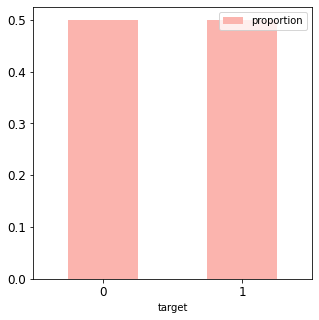

In [9]:
target_dist.plot(x='target', y='proportion', kind='bar', rot=0, \
                 colormap='Pastel1', fontsize=12, figsize=(5,5))

In [83]:
copy = data.copy()
copy['word_count'] = copy['text'].apply(lambda x: len(x.split(' ')))

In [84]:
def avg_word_length(text):
    words = text.split(' ')
    length = [len(w) for w in words]
    return math.ceil(sum(length) / len(length))

copy['avg_word_length'] = copy['text'].apply(avg_word_length)

In [12]:
copy.head(5)

,text,target,word_count,avg_word_length
0,A nice listen: I have always beed a huge stars...,1,135,4
1,I am Very satisfied with this order: It was a ...,1,26,5
2,Christmas Present: I got this for my son for C...,1,79,5
3,Prob works for some doors but not ours: We hav...,0,134,5
4,"can you say 'rip off'?: These bulbs, while ill...",0,176,5


In [13]:
copy.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
target,360000.0,0.500000,0.500001,0.0,0.0,0.5,1.0,1.0
word_count,360000.0,78.471886,42.831131,2.0,42.0,70.0,108.0,223.0
avg_word_length,360000.0,5.032367,0.530537,2.0,5.0,5.0,5.0,97.0


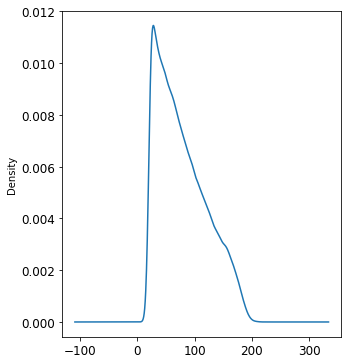

In [14]:
copy.word_count.plot(kind='kde', fontsize=12, figsize=(5,6))

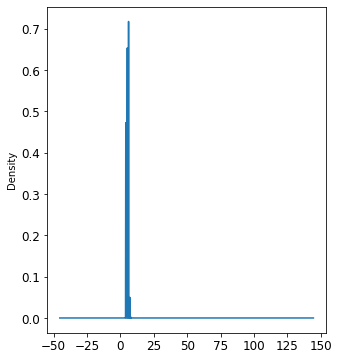

In [15]:
copy.avg_word_length.plot(kind='kde', fontsize=12, figsize=(5,6))

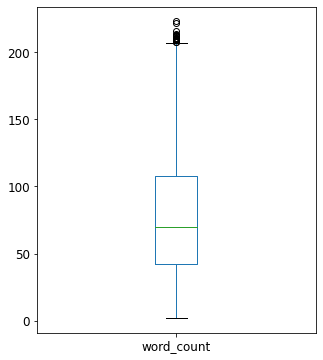

In [16]:
copy.word_count.plot(kind='box', fontsize=12, figsize=(5,6))

In [19]:
reserved_words = ["EMAIL", "NUMBER", "MENTION", "URL"]
token_dict = {
            "ca": "can",
            "wo": "will",
            "sha": "shall",
            "'ve": "have",
            "'ll": "will",
            "'m": "am",
            "n't": "not",
            "'re": "are",
        }
word_dict = {
            "cant": "can not",
            "couldnt": "could not",
            "wont": "will not",
            "pls": "please",
            "plz": "please",
            "youre": "you are",
            "theyre": "they are",
            "ive": "I have",
            "havent": "have not",
            "hasnt": "has not",
            "hadnt": "had not",
            "im": "I am",
            "didnt": "did not",
            "dont": "do not",
            "doesnt": "does not",
            "gotta": "got to",
            "wanna": "want to",
            "gonna": "going to",
            "wannabe": "want to be",
            "cannot": "can not",
        }

In [80]:
def substitute(doc):
        doc = re.sub(r"<br />", " ", doc)
        doc = re.sub(r"\S+@\S+", " EMAIL ", doc)
        doc = re.sub(r"@\S+", " MENTION ", doc)
        doc = re.sub(r"https?:\S+|http?:\S+", " URL ", doc)
        doc = re.sub(r"(\d+\-\d+)|\d+", " NUMBER ", doc)
        doc = re.sub(r"[^A-Za-z']", " ", doc)

        return doc

def expand(token):
        if token in reserved_words:
            return token
        token = token.lower()
        if token.lower().strip() == "let's":
            return "let us"

        if token.lower().strip() == "'twas":
            return "it was"

        if word_dict.get(token, None):
            return word_dict.get(token)

        tokens = word_tokenize(token)
        if len(tokens) == 1:
            return word_dict.get(tokens[0], tokens[0])
        for i in range(len(tokens)):
            tokens[i] = token_dict.get(tokens[i], tokens[i])

        return " ".join(tokens)

def preprocess(doc):
        doc = normalize('NFD',doc).encode('ascii', 'ignore').decode('utf-8')
        doc = substitute(doc)
        tokens = doc.split()
        doc = " ".join([expand(w) for w in tokens])

        tokens = doc.split()
        tokens = [word for word in tokens if word.isalpha()]

        tokens = [
            word.lower() if word not in reserved_words else word for word in tokens
        ]

        return " ".join(tokens)

In [81]:
preprocess("😂 @mama124 Im gonna enter http:bit.ly.12673/ab \
for 30th time :| don't know why cant i České Budějovic á Ś cé")

'MENTION i am going to enter URL for NUMBER th time do not know why can not i ceske budejovic a s ce'

In [85]:
%%time 
copy['text'] = copy['text'].apply(preprocess)

CPU times: user 26min 58s, sys: 1.43 s, total: 27min
Wall time: 27min


In [88]:
# copy[cols].to_csv('/content/drive/MyDrive/sentiment/data/data_preprocessed.csv')